# Try to add a nifty model for sampling the input map

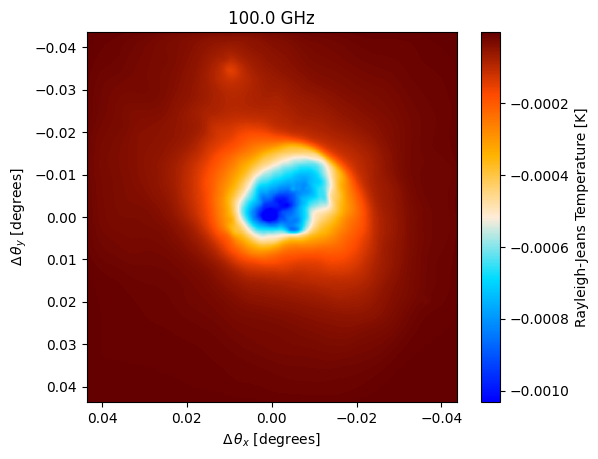

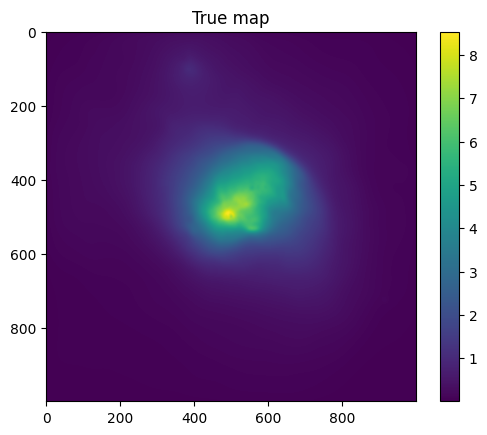

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

# input_map.data[0] = input_map.data[0]*0. + input_map.data[0].mean()

input_map.to(units="K_RJ").plot()
plt.show()


# Sava mapdata as jax array
mapdata_input = np.float64((input_map.data[0].T)*-1e7)

plt.imshow(mapdata_input)
plt.colorbar()
plt.title('True map')
plt.show()

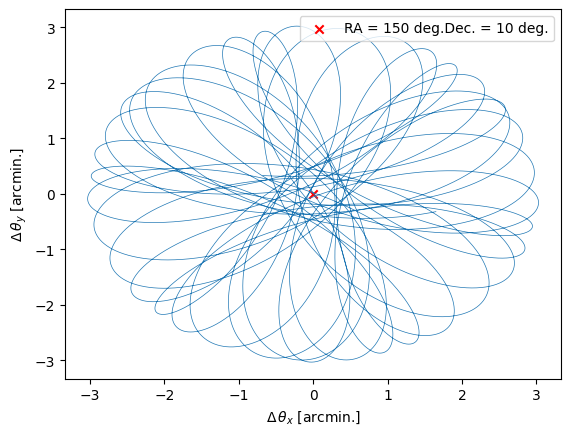

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                # atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

# sim_noise = maria.Simulation(instrument, 
#                                 plan=plan,
#                                 site="llano_de_chajnantor", 
#                                 # map=input_map,
#                                 # noise=False,
#                                 # atmosphere="2d",
#                                 # cmb="generate",
#                                 )

# tod_noise = sim_noise.run()

2024-07-31 15:46:56.432 INFO: Constructed instrument.
2024-07-31 15:46:56.432 INFO: Constructed plan.
2024-07-31 15:46:56.433 INFO: Constructed site.
2024-07-31 15:46:56.956 INFO: Constructed boresight.
2024-07-31 15:46:57.177 INFO: Constructed offsets.


Initialized base in 746 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]

mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726027824180198e-05


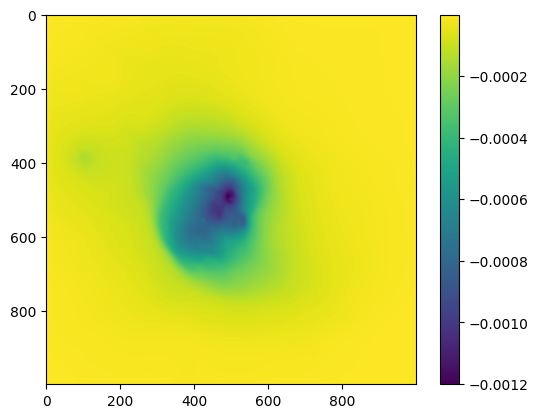

In [5]:
from maria.map.mappers import BinMapper

mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

# output_truthmap.plot()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

plt.imshow(mapdata_truth[0])
plt.colorbar()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-07-31 15:47:05.332 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-07-31 15:47:05.333 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-07-31 15:47:05.402958: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [8]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [9]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

## Test TOD agreement for noise-free map

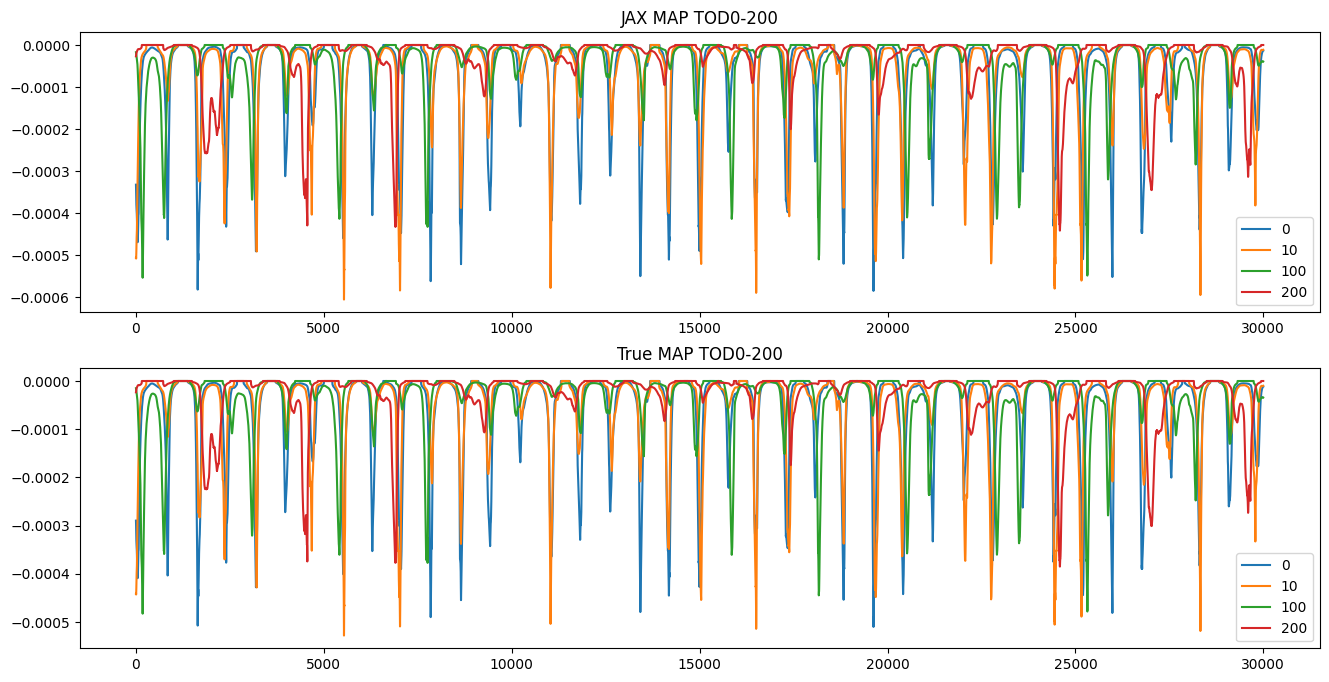

In [10]:
jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

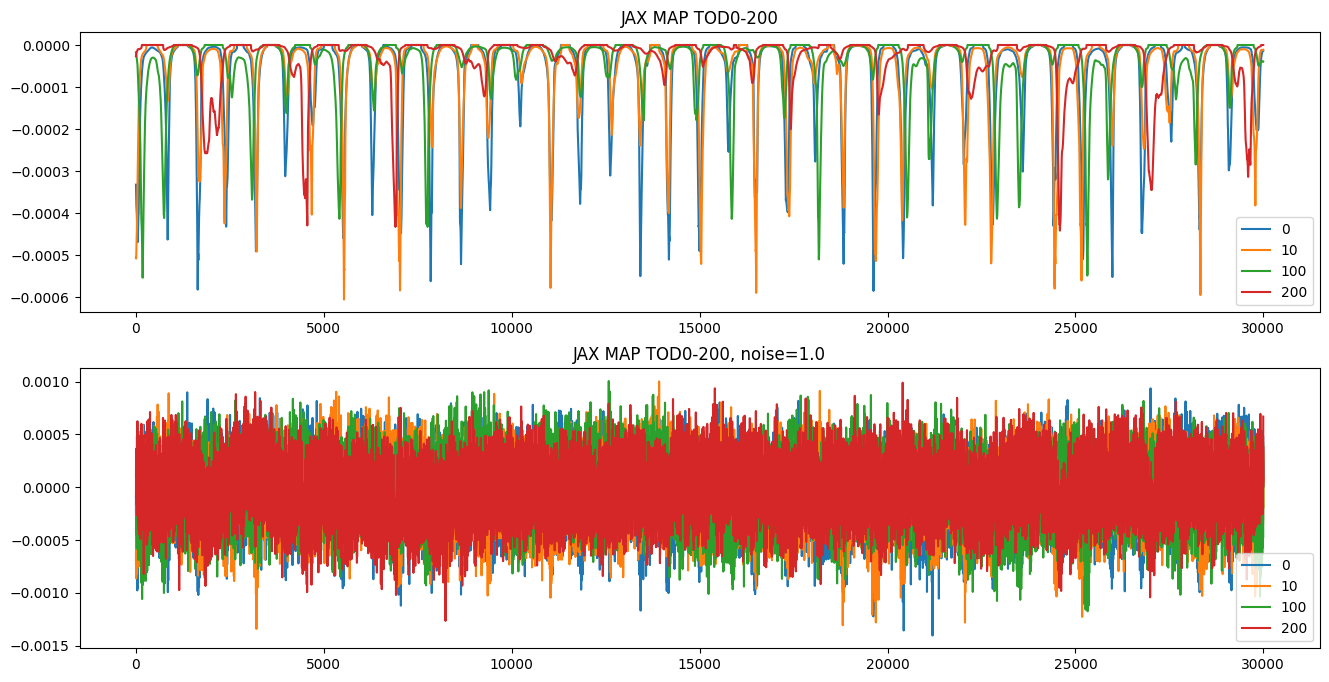

In [11]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
noised_jax_tod = jax_tods + np.float64(tod_truthmap.components['noise']*noiselevel)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

In [12]:
# dims = (128, 128)
dims = (1000, 1000)
# dims = (500, 500)

# Map model

# correlated field zero mode GP offset and stddev
cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [140]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
noise_cov_inv_map = lambda x: 1e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 5e-6**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_tod = jft.Gaussian( noised_jax_tod, noise_cov_inv_tod).amend(signal_response_tod)
lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [141]:
key, sub = random.split(key)
print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(9097451.13562605, dtype=float64),
	 'cfmapax1loglogavgslope': Array(-421218.93439932, dtype=float64),
	 'cfmapxi': Array([[ 9.81661305e+01, -1.65956406e+07,  1.00150406e+06, ...,
	        -2.02874179e+05,  2.76157358e+05,  8.81819968e+06],
	       [-1.87232305e+07,  3.90293845e+06,  1.30688602e+05, ...,
	        -9.66393243e+04,  1.86634219e+05,  5.25174515e+06],
	       [-6.49591851e+05, -2.99922863e+04,  5.78448877e+05, ...,
	         2.47862587e+05,  2.82380369e+05,  1.79308979e+05],
	       ...,
	       [-5.35960432e+04, -5.63054964e+05,  1.06138247e+05, ...,
	         5.60790383e+03,  2.47324813e+05,  4.56969245e+04],
	       [ 1.51252947e+06, -7.85477782e+05, -3.44063609e+05, ...,
	         9.61080387e+04,  6.76331921e+05, -9.38277812e+04],
	       [-8.66309588e+06,  3.58676896e+06, -1.58867865e+05, ...,
	         6.26414191e+04, -1.84448196e+05, -3.25640493e+05]],      dtype=float64),
	 'cfmapzeromode': Array(10.16882563, dtype=float64)}
)

# MAP fit

In [142]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-12
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-7

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:4.258941e+01 ➽:1.000003e-01
M: Iteration 1 ⛰:+9.392557e+09 Δ⛰:1.596180e+10
M: →:1.0 ↺:False #∇²:12 |↘|:1.947636e+01 ➽:1.000003e-01
M: Iteration 2 ⛰:+8.403952e+09 Δ⛰:9.886058e+08
M: →:1.0 ↺:False #∇²:18 |↘|:1.423168e+01 ➽:1.000003e-01
M: Iteration 3 ⛰:+8.284661e+09 Δ⛰:1.192904e+08
M: →:1.0 ↺:False #∇²:24 |↘|:6.811035e+00 ➽:1.000003e-01
M: Iteration 4 ⛰:+8.269346e+09 Δ⛰:1.531466e+07
M: →:1.0 ↺:False #∇²:30 |↘|:5.349102e+00 ➽:1.000003e-01
M: Iteration 5 ⛰:+8.261651e+09 Δ⛰:7.695780e+06
M: →:1.0 ↺:False #∇²:36 |↘|:4.252523e+00 ➽:1.000003e-01
M: Iteration 6 ⛰:+8.256501e+09 Δ⛰:5.150137e+06
M: →:1.0 ↺:False #∇²:42 |↘|:4.358338e+00 ➽:1.000003e-01
M: Iteration 7 ⛰:+8.252862e+09 Δ⛰:3.638596e+06
M: →:1.0 ↺:False #∇²:48 |↘|:3.265133e+00 ➽:1.000003e-01
M: Iteration 8 ⛰:+8.250096e+09 Δ⛰:2.766091e+06
M: →:1.0 ↺:False #∇²:54 |↘|:3.830944e+00 ➽:1.000003e-01
M: Iteration 9 ⛰:+8.247926e+09 Δ⛰:2.169861e+06
M: →:1.0 ↺:False #∇²:62 |↘|:3.679692e+01 ➽:1.0

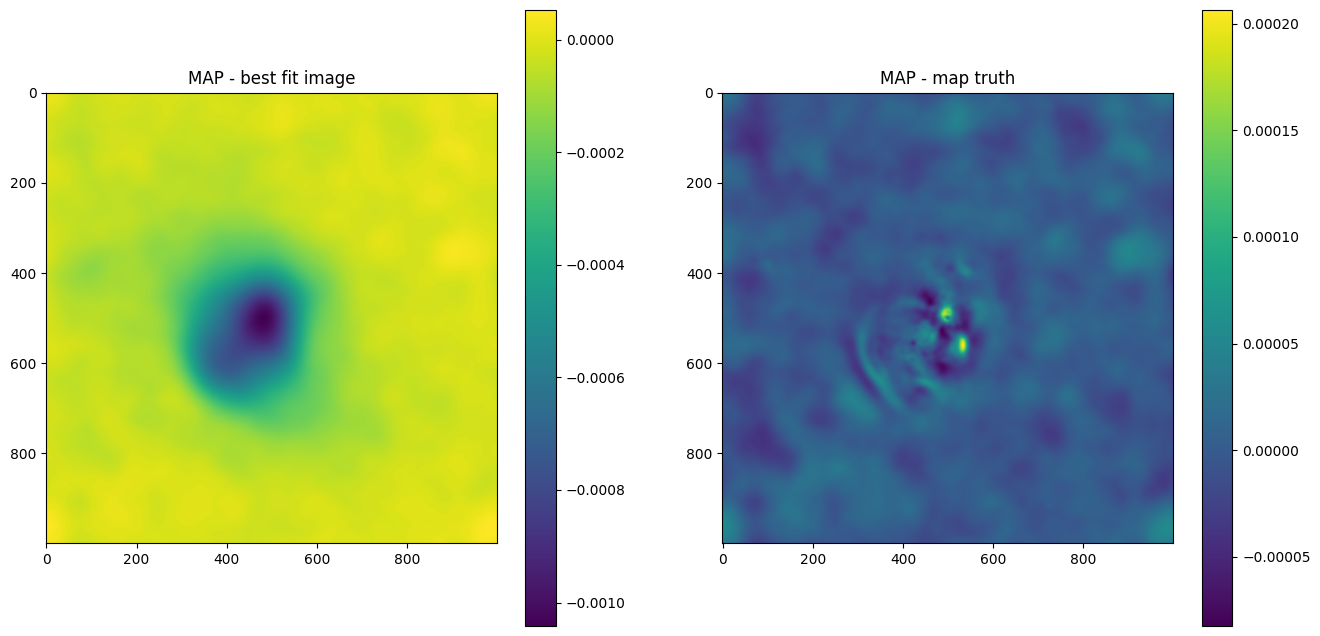

In [143]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

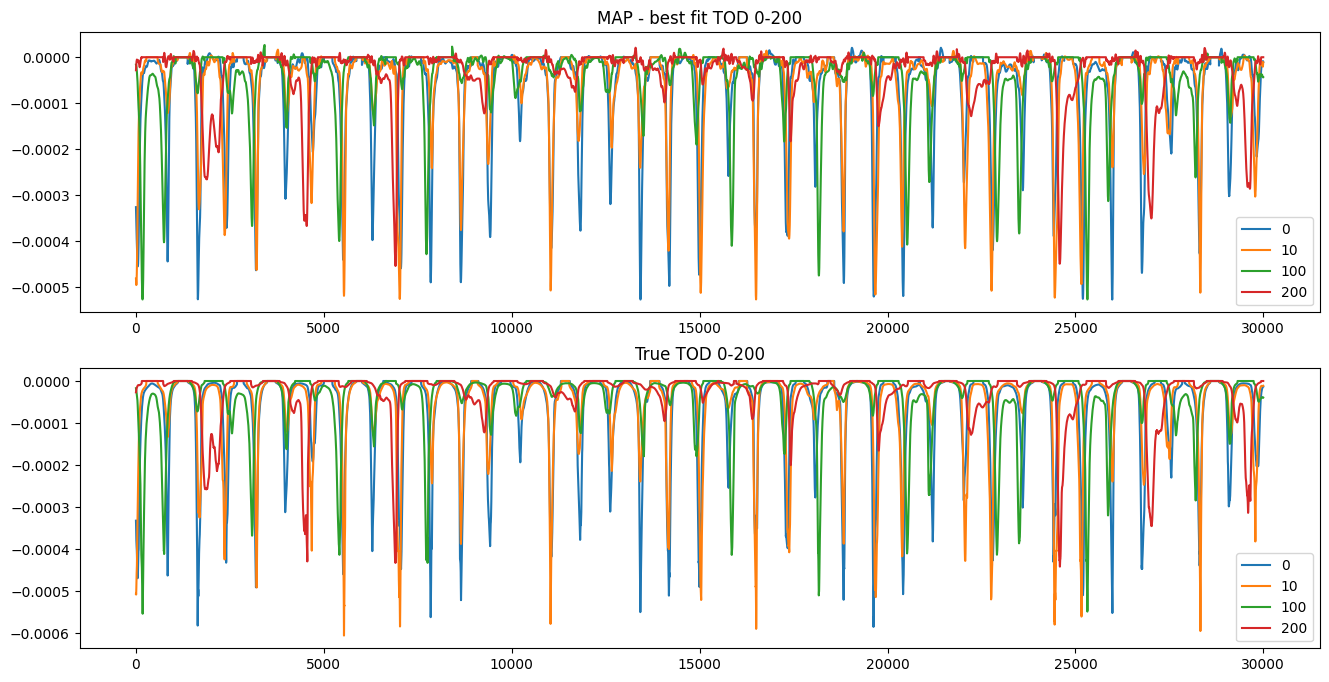

In [144]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()

plt.show()

In [145]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+1.6113e+10 Δ⛰:inf ➽:1.0000e+00
SL: Iteration 1 ⛰:+9.6387e+09 Δ⛰:6.4740e+09 ➽:1.0000e+00
SL: Iteration 2 ⛰:+6.1420e+09 Δ⛰:3.4967e+09 ➽:1.0000e+00
SL: Iteration 3 ⛰:+5.0984e+09 Δ⛰:1.0436e+09 ➽:1.0000e+00
SL: Iteration 4 ⛰:+4.1098e+09 Δ⛰:9.8854e+08 ➽:1.0000e+00
SL: Iteration 5 ⛰:+3.8444e+09 Δ⛰:2.6546e+08 ➽:1.0000e+00
SL: Iteration 6 ⛰:+3.4620e+09 Δ⛰:3.8235e+08 ➽:1.0000e+00
SL: Iteration 7 ⛰:+3.0593e+09 Δ⛰:4.0272e+08 ➽:1.0000e+00
SL: Iteration 8 ⛰:+2.5494e+09 Δ⛰:5.0984e+08 ➽:1.0000e+00
SL: Iteration 9 ⛰:+2.4497e+09 Δ⛰:9.9704e+07 ➽:1.0000e+00
SL: Iteration 10 ⛰:+2.3202e+09 Δ⛰:1.2956e+08 ➽:1.0000e+00
SL: Iteration 11 ⛰:+2.0070e+09 Δ⛰:3.1316e+08 ➽:1.0000e+00
SL: Iteration 12 ⛰:+1.8779e+09 Δ⛰:1.2914e+08 ➽:1.0000e+00
SL: Iteration 13 ⛰:+1.7943e+09 Δ⛰:8.3560e+07 ➽:1.0000e+00
SL: Iteration 14 ⛰:+1.5829e+09 Δ⛰:2.1147e+08 ➽:1.0000e+00
SL: Iteration 15 ⛰:+1.5077e+09 Δ⛰:7.5208e+07 ➽:1.0000e+00
SL: Iteration 16 ⛰:+1.4248e+09 Δ⛰:8.2809e+07 ➽:1.0000e+00
SL: 

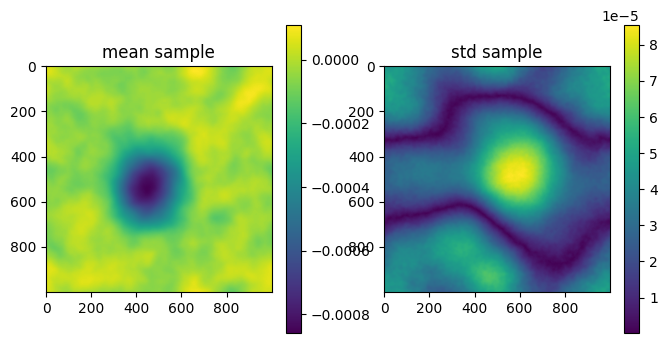

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.2028e+10 Δ⛰:inf ➽:1.0000e+00
SL: Iteration 1 ⛰:+1.0847e+09 Δ⛰:1.0943e+10 ➽:1.0000e+00
SL: Iteration 2 ⛰:+7.6035e+08 Δ⛰:3.2435e+08 ➽:1.0000e+00
SL: Iteration 3 ⛰:+4.1428e+08 Δ⛰:3.4607e+08 ➽:1.0000e+00
SL: Iteration 4 ⛰:+3.5476e+08 Δ⛰:5.9517e+07 ➽:1.0000e+00
SL: Iteration 5 ⛰:+2.1744e+08 Δ⛰:1.3732e+08 ➽:1.0000e+00
SL: Iteration 6 ⛰:+1.3108e+08 Δ⛰:8.6359e+07 ➽:1.0000e+00
SL: Iteration 7 ⛰:+1.2828e+08 Δ⛰:2.7959e+06 ➽:1.0000e+00
SL: Iteration 8 ⛰:+8.5716e+07 Δ⛰:4.2568e+07 ➽:1.0000e+00
SL: Iteration 9 ⛰:+7.2603e+07 Δ⛰:1.3113e+07 ➽:1.0000e+00
SL: Iteration 10 ⛰:+4.0240e+07 Δ⛰:3.2363e+07 ➽:1.0000e+00
SL: Iteration 11 ⛰:+3.3543e+07 Δ⛰:6.6970e+06 ➽:1.0000e+00
SL: Iteration 12 ⛰:+2.8208e+07 Δ⛰:5.3348e+06 ➽:1.0000e+00
SL: Iteration 13 ⛰:+2.3873e+07 Δ⛰:4.3349e+06 ➽:1.0000e+00
SL: Iteration 14 ⛰:+1.6303e+07 Δ⛰:7.5696e+06 ➽:1.0000e+00
SL: Iteration 15 ⛰:+1.5764e+07 Δ⛰:5.3934e+05 ➽:1.0000e+00
SL: Iteration 16 ⛰:+1.4952e+07 Δ⛰:8.1195e+05 ➽:1.0000e+00
SL: 

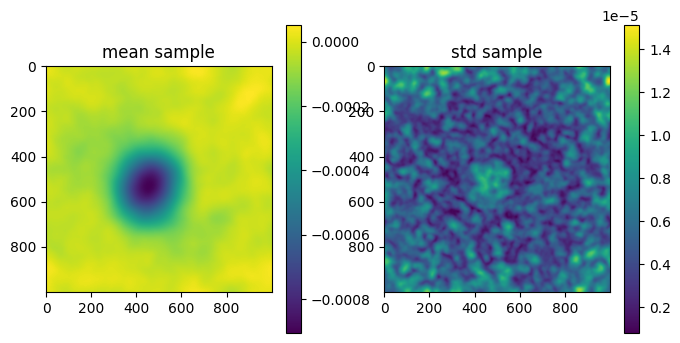

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+1.0836e+10 Δ⛰:inf ➽:1.0000e+00
SL: Iteration 1 ⛰:+1.5023e+09 Δ⛰:9.3334e+09 ➽:1.0000e+00
SL: Iteration 2 ⛰:+1.0471e+09 Δ⛰:4.5522e+08 ➽:1.0000e+00
SL: Iteration 3 ⛰:+4.1733e+08 Δ⛰:6.2977e+08 ➽:1.0000e+00
SL: Iteration 4 ⛰:+1.4711e+08 Δ⛰:2.7022e+08 ➽:1.0000e+00
SL: Iteration 5 ⛰:+1.1853e+08 Δ⛰:2.8580e+07 ➽:1.0000e+00
SL: Iteration 6 ⛰:+7.6510e+07 Δ⛰:4.2023e+07 ➽:1.0000e+00
SL: Iteration 7 ⛰:+7.4806e+07 Δ⛰:1.7040e+06 ➽:1.0000e+00
SL: Iteration 8 ⛰:+4.2698e+07 Δ⛰:3.2108e+07 ➽:1.0000e+00
SL: Iteration 9 ⛰:+3.1692e+07 Δ⛰:1.1006e+07 ➽:1.0000e+00
SL: Iteration 10 ⛰:+2.6909e+07 Δ⛰:4.7829e+06 ➽:1.0000e+00
SL: Iteration 11 ⛰:+2.4279e+07 Δ⛰:2.6307e+06 ➽:1.0000e+00
SL: Iteration 12 ⛰:+1.2701e+07 Δ⛰:1.1578e+07 ➽:1.0000e+00
SL: Iteration 13 ⛰:+1.0437e+07 Δ⛰:2.2637e+06 ➽:1.0000e+00
SL: Iteration 14 ⛰:+9.8944e+06 Δ⛰:5.4293e+05 ➽:1.0000e+00
SL: Iteration 15 ⛰:+9.0091e+06 Δ⛰:8.8525e+05 ➽:1.0000e+00
SL: Iteration 16 ⛰:+8.6302e+06 Δ⛰:3.7890e+05 ➽:1.0000e+00
SL: 

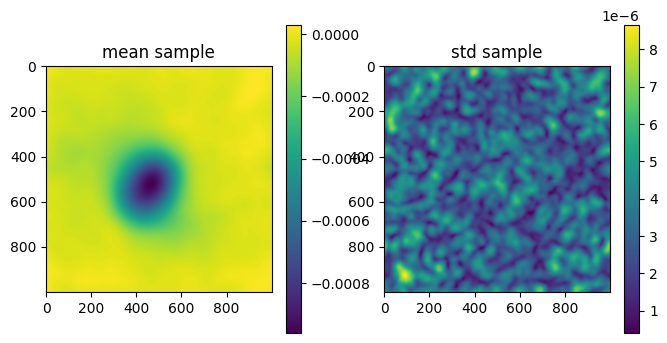

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+8.5642e+09 Δ⛰:inf ➽:1.0000e+00
SL: Iteration 1 ⛰:+1.1845e+09 Δ⛰:7.3797e+09 ➽:1.0000e+00
SL: Iteration 2 ⛰:+7.9334e+08 Δ⛰:3.9114e+08 ➽:1.0000e+00
SL: Iteration 3 ⛰:+2.6889e+08 Δ⛰:5.2446e+08 ➽:1.0000e+00
SL: Iteration 4 ⛰:+2.4040e+08 Δ⛰:2.8483e+07 ➽:1.0000e+00
SL: Iteration 5 ⛰:+1.1362e+08 Δ⛰:1.2678e+08 ➽:1.0000e+00
SL: Iteration 6 ⛰:+8.5499e+07 Δ⛰:2.8121e+07 ➽:1.0000e+00
SL: Iteration 7 ⛰:+7.0920e+07 Δ⛰:1.4578e+07 ➽:1.0000e+00
SL: Iteration 8 ⛰:+5.5074e+07 Δ⛰:1.5846e+07 ➽:1.0000e+00
SL: Iteration 9 ⛰:+2.0414e+07 Δ⛰:3.4660e+07 ➽:1.0000e+00
SL: Iteration 10 ⛰:+1.9577e+07 Δ⛰:8.3677e+05 ➽:1.0000e+00
SL: Iteration 11 ⛰:+1.4015e+07 Δ⛰:5.5622e+06 ➽:1.0000e+00
SL: Iteration 12 ⛰:+6.6426e+06 Δ⛰:7.3720e+06 ➽:1.0000e+00
SL: Iteration 13 ⛰:+4.6834e+06 Δ⛰:1.9592e+06 ➽:1.0000e+00
SL: Iteration 14 ⛰:+4.6756e+06 Δ⛰:7.7909e+03 ➽:1.0000e+00
SL: Iteration 15 ⛰:+3.9430e+06 Δ⛰:7.3266e+05 ➽:1.0000e+00
SL: Iteration 16 ⛰:+3.7866e+06 Δ⛰:1.5636e+05 ➽:1.0000e+00
SL: 

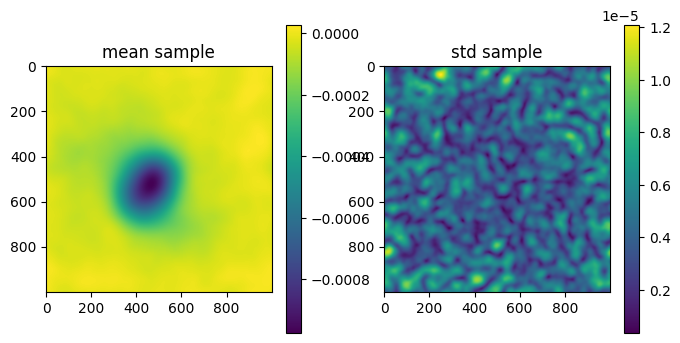

In [150]:
n_it = 4
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-12
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-5
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=20),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

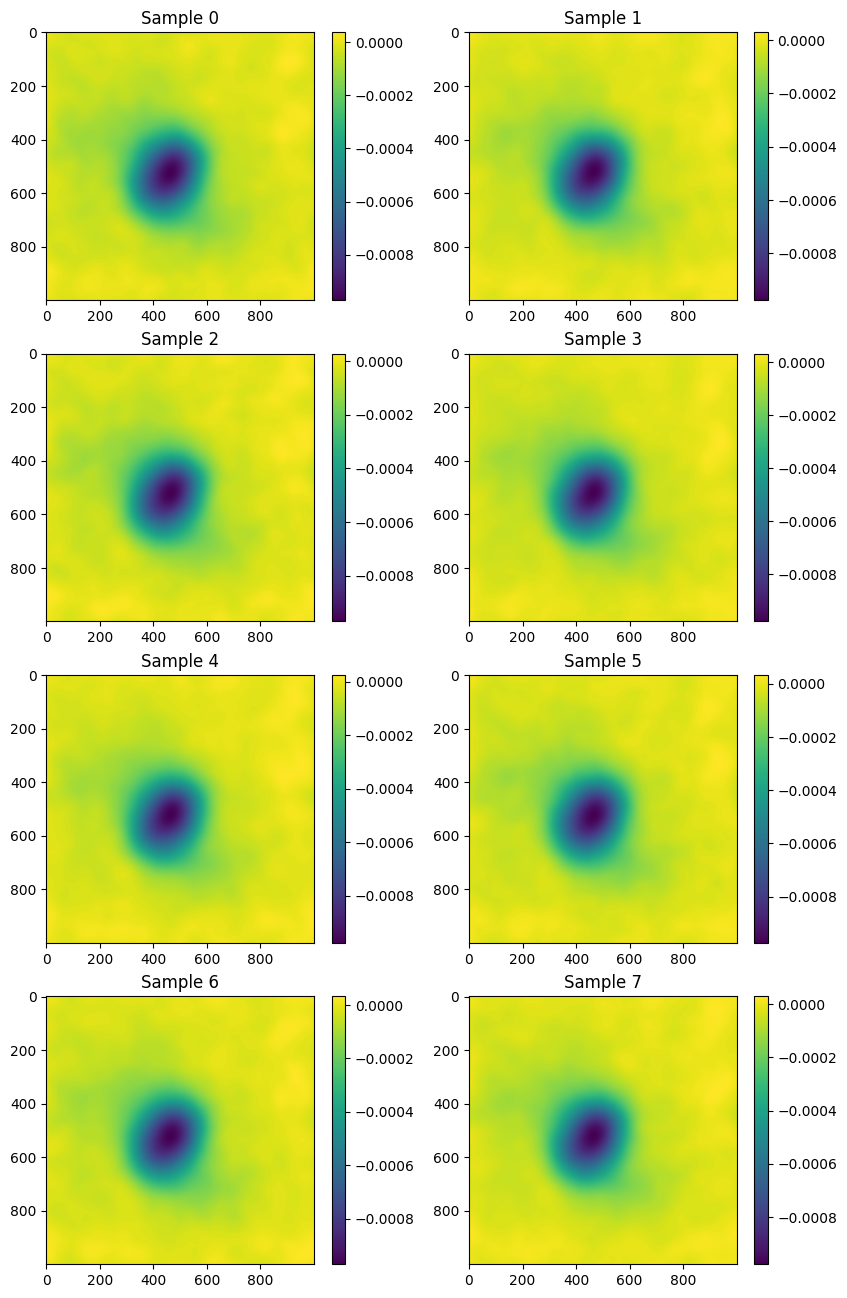

In [151]:
# plot all samples
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))
    im = axes[i//2][i%2].imshow(gp_map(s))
    axes[i//2][i%2].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()

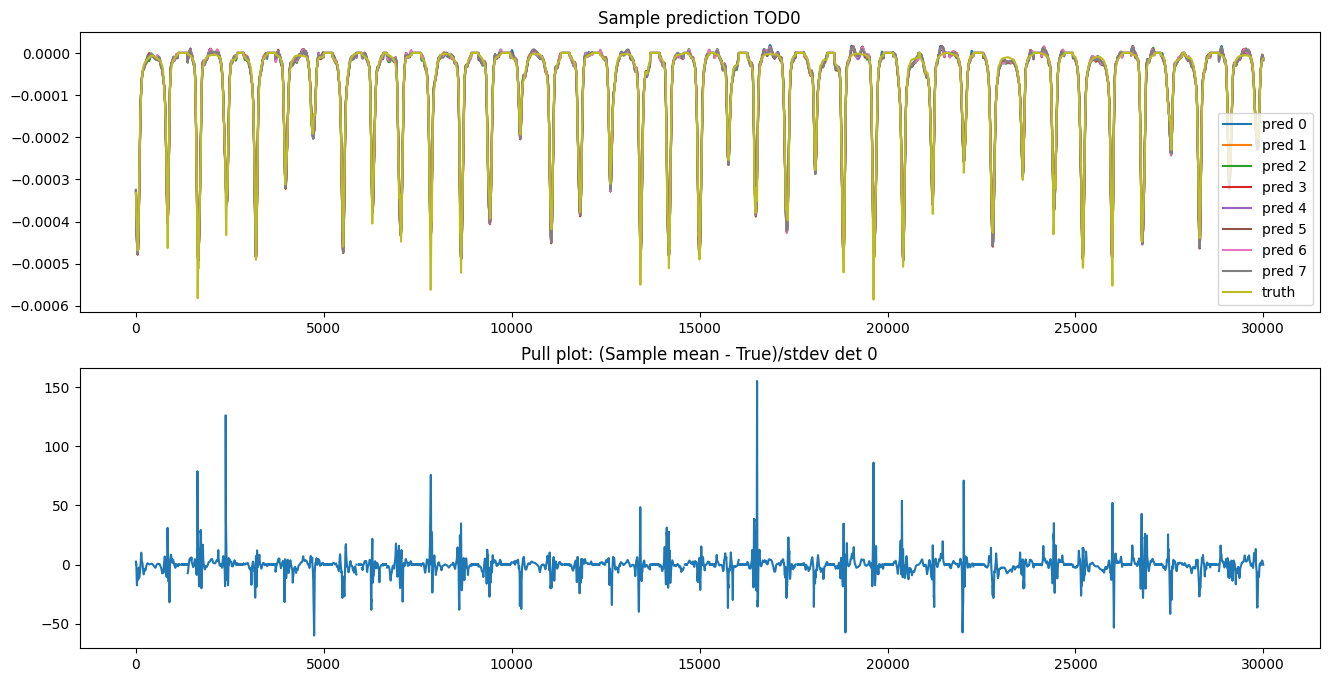

In [152]:
# plot time-series for det 0 for all samples:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

i = 0
for s in samples:

    axes[0].plot(signal_response_tod(s)[0], label=f"pred {i}")
    # axes[1].plot((signal_response_tod(s)[0] - jax_tods[0])/std[0], label=i)
    i += 1

axes[0].plot(jax_tods[0], label="truth")
axes[0].set_title("Sample prediction TOD0")
axes[0].legend()

# axes[1].plot(jax_tods[0])
axes[1].plot((mean[0] - jax_tods[0])/std[0])
axes[1].set_title(f"Pull plot: (Sample mean - True)/stdev det 0")
# axes[1].legend()

plt.show()

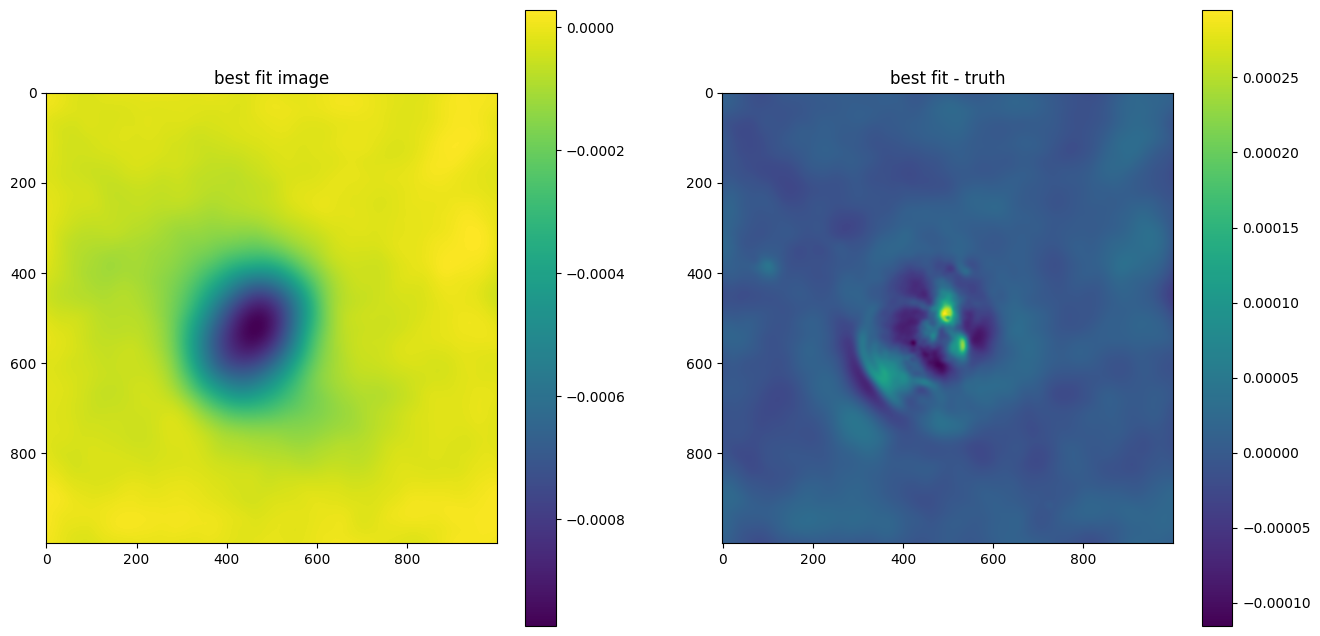

In [153]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('best fit - truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()